In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from CovTypeDataset import CovTypeDataset, PermutedCovTypeDataset
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from utils import EWC, ewc_train, normal_train, test

In [2]:
dataset = CovTypeDataset('./covtype/covtype.data')
permuted_dataset = PermutedCovTypeDataset('./covtype/covtype.data', 6)

In [3]:
epochs = 50
lr = 1e-3
batch_size = 400
sample_size = 2000
hidden_size = 400
num_task = 3

In [4]:
train_loader = []
test_loader = []

In [5]:
def get_sample(dataset: Dataset, sample_size: int):
    sample_idx = random.sample(range(len(dataset)), sample_size)
    return [dataset.__getitem__(idx)[0] for idx in sample_idx]

In [6]:
# Create train and test loaders from the given dataset
def load(dataset: CovTypeDataset):
    train_set, test_set = dataset.random_split(0.2)
    train_loader.append(DataLoader(dataset=train_set, batch_size=batch_size, num_workers=0))
    test_loader.append(DataLoader(dataset=test_set, batch_size=batch_size, num_workers=0))

In [7]:
# Loads random halves from the given dataset as separate train and test loaders
def load_split(dataset: CovTypeDataset):
    train_set1, test_set1, train_set2, test_set2 = dataset.random_split_2_sets(0.2)
    train_loader.append(DataLoader(dataset=train_set1, batch_size=batch_size, num_workers=0))
    test_loader.append(DataLoader(dataset=test_set1, batch_size=batch_size, num_workers=0))
    train_loader.append(DataLoader(dataset=train_set2, batch_size=batch_size, num_workers=0))
    test_loader.append(DataLoader(dataset=test_set2, batch_size=batch_size, num_workers=0))

In [8]:
load_split(dataset)
load(permuted_dataset)

In [9]:
class MLP(nn.Module):
    def __init__(self, num_features, num_classes, hidden_size=400):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, input):
        x = F.leaky_relu(self.fc1(input))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc4(x))
        return x

In [10]:
def standard_process(epochs, use_cuda=True, weight=True):
    model = MLP(54, 7, hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-5)

    loss, acc, avg_acc = {}, {}, []
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, optimizer, train_loader[task]))
            acc_sum = 0
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader[sub_task]))
                acc_sum += acc[sub_task][-1]
            avg_acc.append(acc_sum / (task + 1))
        if task == 0 and weight:
            weight = model.state_dict()
    return loss, acc, weight, avg_acc, model

def ewc_process(epochs, importance, use_cuda=True, weight=None):
    model = MLP(54, 7, hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-5)

    loss, acc, ewc, avg_acc = {}, {}, {}, []
    for task in range(num_task):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in tqdm(range(epochs)):
                    loss[task].append(normal_train(model, optimizer, train_loader[task]))
                    acc[task].append(test(model, test_loader[task]))
                    avg_acc.append(acc[task][-1])
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + get_sample(train_loader[sub_task].dataset, sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for _ in tqdm(range(epochs)):
                loss[task].append(ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance))
                acc_sum = 0
                for sub_task in range(task + 1):
                    acc[sub_task].append(test(model, test_loader[sub_task]))
                    acc_sum += acc[sub_task][-1]
                avg_acc.append(acc_sum / (task + 1))

    return loss, acc, avg_acc, model

In [11]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v)
    plt.ylim(0, 1)

In [12]:
loss, acc, weight, avg_acc, model = standard_process(epochs)

100%|██████████| 50/50 [06:30<00:00,  7.80s/it]


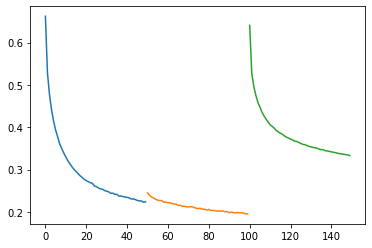

In [13]:
for k in loss:
    loss[k] = [l.cpu().detach() for l in loss[k]]
loss_plot(loss)

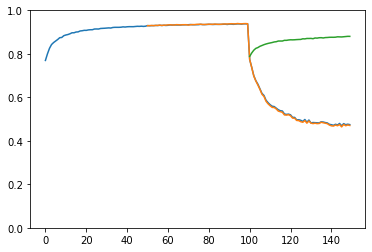

In [14]:
for k in acc:
    acc[k] = [a.cpu().detach() for a in acc[k]]
accuracy_plot(acc)

In [15]:
loss_ewc, acc_ewc, avg_acc_ewc, model_ewc = ewc_process(epochs, importance=1000)

100%|██████████| 50/50 [09:57<00:00, 11.95s/it]


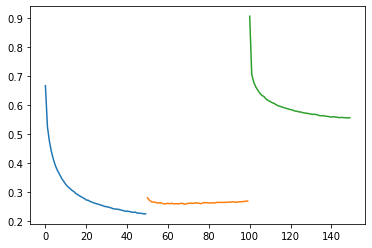

In [16]:
for k in loss_ewc:
    loss_ewc[k] = [l.cpu().detach() for l in loss_ewc[k]]
loss_plot(loss_ewc)

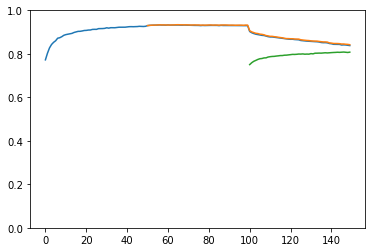

In [17]:
for k in acc_ewc:
    acc_ewc[k] = [a.cpu().detach() for a in acc_ewc[k]]
accuracy_plot(acc_ewc)

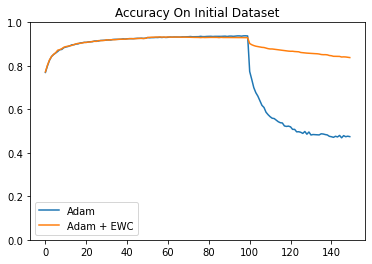

In [18]:
plt.plot(acc[0], label="Adam")
plt.plot(acc_ewc[0], label="Adam + EWC")
plt.title('Accuracy On Initial Dataset')
plt.ylim(0, 1)
plt.legend()

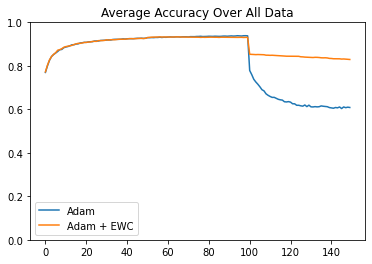

In [19]:
avg_acc = list(map(lambda x: x.cpu().detach(), avg_acc))
avg_acc_ewc = list(map(lambda x: x.cpu().detach(), avg_acc_ewc))
plt.plot(avg_acc, label="Adam")
plt.plot(avg_acc_ewc, label="Adam + EWC")
plt.title('Average Accuracy Over All Data')
plt.ylim(0, 1)
plt.legend()

In [20]:
torch.save(model, 'model')
torch.save(model_ewc, 'model_ewc')